# Microwave Radiometer Temperature and Humidity Retrieval

to do: introduce retrieval

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
import xarray as xr
import seaborn as sns
import sys

import pyOptimalEstimation as pyOE
import pamtra2

sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

In [2]:
%%time
nonScatMWRadTran.doTests()

CPU times: user 95.5 ms, sys: 19.4 ms, total: 115 ms
Wall time: 163 ms


# Load data
The mean $\mathbf{x}_{a}$ and covariance $\mathbb{S}_a$ of the prior have been estimated from the radiosonde data set and are loaded from a NetCDF file. Additionally, the forward operator requires also the height profile and the associated pressure levels. 

In [3]:
allData = xr.open_dataset('data/radiosonde_prior.nc')

x_mean = allData['x_mean']
x_cov = allData['x_cov']
pressure = allData['pressure']
height = allData['height']

The file also contained some atmospheric profiles that were not used to estimate the prior. We will use them to estimate synthetic observations. By this, we can evaluate the retrieval result by comparison with the true atmospheric state. For this example we use the atmospheric profile at Barrow at 2004-03-16T12:00:00

In [4]:
profileII =0
season = 'MAM'

x_truth = allData['x_truth'].isel(time=profileII)
x_truth.time

<xarray.DataArray 'time' ()>
array('2004-03-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2004-03-16T12:00:00

We use the standard frequencies of an HATPRO microwave radiometer

In [5]:
frequencies = [22.24 , 23.04, 23.84, 25.44, 26.24, 27.84, 31.4 , 51.26, 52.28, 53.86,
       54.94, 56.66, 57.3 , 58. ]

# forward operator

Next, we define the forward operator. pyOptimalEstimation requires that the state vector X is the first argument of the forward operator function and the measurement vector Y is returned. 

In [6]:

def forwardRT(X,  pressure=None, zenithAngle=0, frequencies=[]):
    
    temperature, humidity = supporting_routines.splitTQ(X)
    humidity = 10**humidity
    heights = temperature.index
    assert np.all(np.diff(heights)>0)
    
    abs_humidity = supporting_routines.q2a(humidity/1000., pressure, temperature)
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature , # [K]
        pressure , # [Pa]
        abs_humidity, # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB



# Run reference retrieval

## Prepare retrieval
First, we need names for our Y and X variables to avoid any confusion. For Y, we select the frequencies, for X we use a string containing the height in meters and the variable (t or q). 

In [7]:
y_vars = frequencies
x_vars = x_mean.state.values
y_vars, x_vars

([22.24,
  23.04,
  23.84,
  25.44,
  26.24,
  27.84,
  31.4,
  51.26,
  52.28,
  53.86,
  54.94,
  56.66,
  57.3,
  58.0],
 array(['00008_q', '00008_t', '00107_q', '00107_t', '00207_q', '00207_t',
        '00308_q', '00308_t', '00408_q', '00408_t', '00508_q', '00508_t',
        '00608_q', '00608_t', '00707_q', '00707_t', '00807_q', '00807_t',
        '00907_q', '00907_t', '01007_q', '01007_t', '01107_q', '01107_t',
        '01207_q', '01207_t', '01307_q', '01307_t', '01407_q', '01407_t',
        '01507_q', '01507_t', '01607_q', '01607_t', '01707_q', '01707_t',
        '01807_q', '01807_t', '01907_q', '01907_t', '02007_q', '02007_t',
        '02107_q', '02107_t', '02207_q', '02207_t', '02307_q', '02307_t',
        '02407_q', '02407_t', '02507_q', '02507_t', '02607_q', '02607_t',
        '02707_q', '02707_t', '02807_q', '02807_t', '02907_q', '02907_t',
        '03007_q', '03007_t', '03107_q', '03107_t', '03207_q', '03207_t',
        '03307_q', '03307_t', '03407_q', '03407_t', '03507_q',

Based on the true profile, we create a synthetic observation. Auxiliary data for the forward operator is stored in the `forwardKwArgs` dictionary.

In [8]:
forwardKwArgs = dict(
    pressure=pressure.sel(season=season),
    zenithAngle=0,
    frequencies=frequencies)

y_obs = forwardRT(x_truth.to_pandas(), **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

y_obs

22.24     11.393152
23.04     11.280026
23.84     10.818282
25.44     10.141381
26.24     10.055835
27.84     10.239584
31.40     11.663354
51.26    105.919424
52.28    144.158671
53.86    230.205311
54.94    252.947588
56.66    253.317331
57.30    252.656294
58.00    252.100949
dtype: float64

The measurement uncertainty is defined as follows:

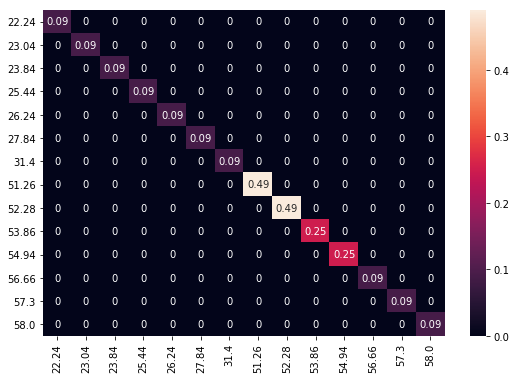

In [9]:
y_noise = pn.Series([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7, 0.7, 0.5, 0.5, 0.3, 0.3, 0.3],index=y_vars)
y_cor = pn.DataFrame(
            np.diag(y_noise.values**2),
            index=y_vars,
            columns=y_vars,
        )
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(y_cor, annot=True, fmt = 'g', ax=ax)

And the prior is obtained from the mean and correlation matrix of the prior. We plot them separately for T and q. Note how the Tropopause can be clearly seen.

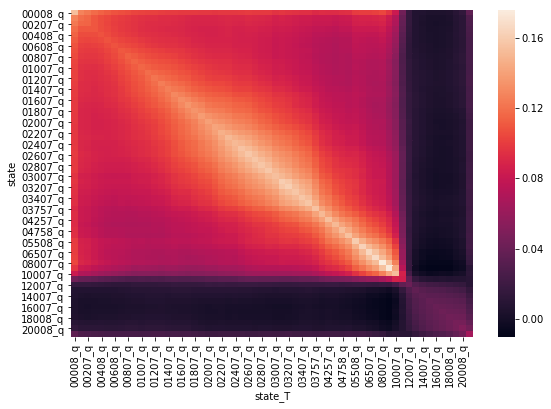

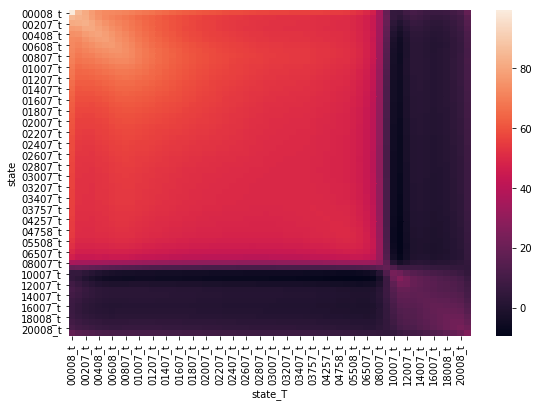

In [10]:
x_a = x_mean.sel(season=season).to_pandas()[x_vars]
x_cor = x_cov.sel(season=season).to_pandas().loc[x_vars,x_vars]

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(x_cor.iloc[::2,::2], ax=ax)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(x_cor.iloc[1::2,1::2], ax=ax)

Using `pyOptimalEstimation`, we create an object named `oe_ref` containing all the required information.

In [11]:
oe_ref = pyOE.optimalEstimation(
    x_vars,
    x_a,
    x_cor,
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth.to_pandas(),
    forwardKwArgs=forwardKwArgs,
)

## run retrieval
The reference run using a prior based on December, January and February radiosondes. 

In [12]:
oe_ref.doRetrieval()

5.03 s, iteration 1, degrees of freedom: 3.70 of 120. convergence criteria NOT fullfilled  6.181
7.64 s, iteration 2, degrees of freedom: 3.68 of 120. convergence criteria fullfilled  0.044
10.36 s, iteration 3, degrees of freedom: 3.68 of 120.  Done.  0.000


True

## Analyze the results
Plot the result

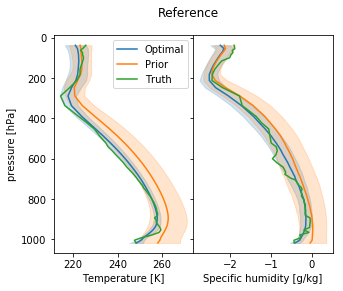

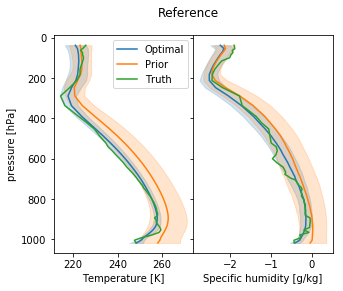

In [13]:

supporting_routines.plotMwrResults(oe_ref, h=pressure.sel(season=season)/100, hlabel ='pressure [hPa]', title='Reference')

Estimate the RMS for X and Y.

In [14]:
T_op, Q_op = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X: T',np.sqrt(np.mean((T_op-T_truth)**2)))
print('RMS X: Q',np.sqrt(np.mean((10**Q_op-10**Q_truth)**2)))
print('RMS Y', np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))


RMS X: T 1.8188780358756458
RMS X: Q 0.07934916184554862
RMS Y 0.1372346733717641


Make statistical tests whether

1. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$
2. the observation $\mathbf{y}_{truth}$ corresponding to $\mathbf{x}_{truth}$ agrees with the prior $\mathbb{S}_a$
3. $\mathbf{y}_{truth}$  agrees with the measurement $\mathbf{y}_{obs}$ given the uncertainties $\mathbb{S}_y$ 
4. the measurement $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$

In [15]:
print(oe_ref.chiSquareTest()[0])


Warning. Singular Matrix with rank 6 instead of 14
Warning. Singular Matrix with rank 10 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


Test whether retrieval is moderately linear

In [16]:
print(oe_ref.linearityTest()[1] < oe_ref.linearityTest()[2])

True


# Run modified retrieval

## all seasons for prior
Use prior based on all seasons

4.68 s, iteration 1, degrees of freedom: 3.76 of 120. convergence criteria NOT fullfilled  55.343
7.35 s, iteration 2, degrees of freedom: 3.70 of 120. convergence criteria fullfilled  1.237
10.33 s, iteration 3, degrees of freedom: 3.69 of 120.  Done.  0.006
RMS X [2.345184630958286, 0.1569198826856209]
RMS Y 0.12854612367035995
Warning. Singular Matrix with rank 6 instead of 14
Warning. Singular Matrix with rank 10 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


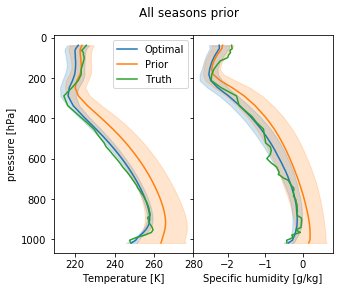

In [17]:
oe_all = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='all').to_pandas(),
    x_cov.sel(season='all').to_pandas(),
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_all.doRetrieval()

supporting_routines.plotMwrResults(oe_all, h=pressure.sel(season=season)/100, hlabel ='pressure [hPa]', title='All seasons prior')
print('RMS X', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_all.x_op), supporting_routines.splitTQ(oe_all.x_truth))])
print('RMS Y', np.sqrt(np.mean((oe_all.y_obs - oe_all.y_op)**2)) )

print(oe_all.chiSquareTest()[0])

## summer

Use summer prior instead of winter

6.03 s, iteration 1, degrees of freedom: 3.84 of 120. convergence criteria NOT fullfilled  1232.908
11.43 s, iteration 2, degrees of freedom: 3.59 of 120. convergence criteria NOT fullfilled  91.788
15.50 s, iteration 3, degrees of freedom: 3.51 of 120. convergence criteria NOT fullfilled  2.334
20.94 s, iteration 4, degrees of freedom: 3.49 of 120. convergence criteria fullfilled  0.006
26.76 s, iteration 5, degrees of freedom: 3.49 of 120.  Done.  0.000
RMS X [4.888412437222851, 0.19898449085733624]
RMS Y 0.3253269706674038
Warning. Singular Matrix with rank 6 instead of 14
Warning. Singular Matrix with rank 10 instead of 120
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


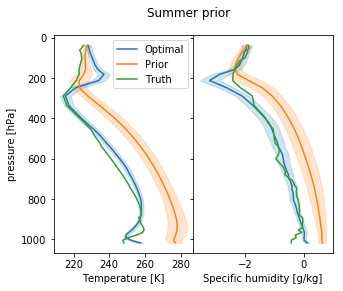

In [18]:
oe_sum = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='JJA').to_pandas(),
    x_cov.sel(season='JJA').to_pandas(),
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_sum.doRetrieval()

supporting_routines.plotMwrResults(oe_sum, h=pressure.sel(season=season)/100, hlabel ='pressure [hPa]', title='Summer prior')

print('RMS X', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_sum.x_op), supporting_routines.splitTQ(oe_sum.x_truth))])
print('RMS Y', np.sqrt(np.mean((oe_sum.y_obs - oe_sum.y_op)**2)) )

print(oe_sum.chiSquareTest()[0])


## diagonal prior

6.13 s, iteration 1, degrees of freedom: 3.37 of 120. convergence criteria NOT fullfilled  2.641
8.89 s, iteration 2, degrees of freedom: 3.35 of 120. convergence criteria fullfilled  0.005
10.99 s, iteration 3, degrees of freedom: 3.35 of 120.  Done.  0.000
RMS X [3.714774189363847, 0.14528631506629286]
RMS Y 0.4023741654561554
Warning. Singular Matrix with rank 6 instead of 14
Warning. Singular Matrix with rank 12 instead of 120
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


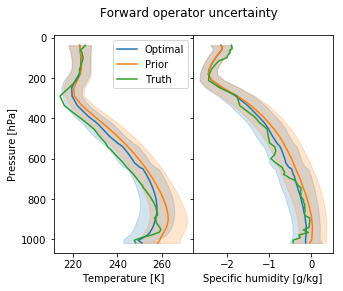

In [19]:
oe_diag = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season=season).to_pandas(),
    np.diag(np.diag(x_cov.sel(season=season))),
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_diag.doRetrieval()



supporting_routines.plotMwrResults(oe_diag, h=pressure.sel(season=season)/100, hlabel ='Pressure [hPa]', title='Forward operator uncertainty')


print('RMS X', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_diag.x_op), supporting_routines.splitTQ(oe_diag.x_truth))])
print('RMS Y', np.sqrt(np.mean((oe_diag.y_obs - oe_diag.y_op)**2)) )

print(oe_diag.chiSquareTest()[0])


## Forward operator uncertainty

Add errors of D. Cimini's study:

In [20]:
Syb = pn.DataFrame(np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 3.0, 3.3, 1.2, 0.3, 0.0, 0.0, 0.0],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.7, 8.7, 9.2, 0.3, 0.3, 0.0, 0.0, 0.0],
    [0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.7, 8.2, 8.7, 0.3, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
]),
                  index=frequencies[::-1],
                  columns=frequencies)

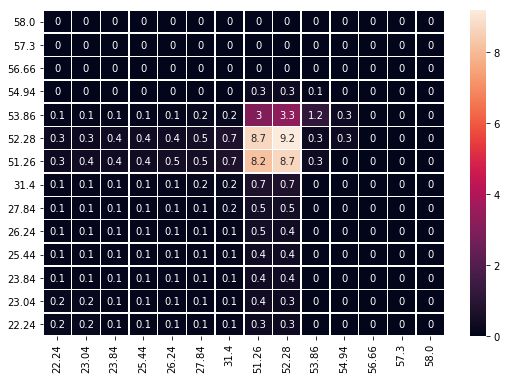

In [21]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Syb, annot=True, linewidths=.5, ax=ax, fmt = 'g')

6.99 s, iteration 1, degrees of freedom: 3.28 of 120. convergence criteria fullfilled  1.268
9.09 s, iteration 2, degrees of freedom: 3.25 of 120.  Done.  0.008
RMS X [2.2936431040279275, 0.14075845816896407]
RMS Y 0.22561970504145332
Warning. Singular Matrix with rank 6 instead of 14
Warning. Singular Matrix with rank 10 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


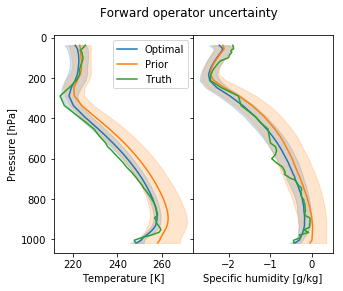

In [22]:
oe_b = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season=season).to_pandas(),
    x_cov.sel(season=season).to_pandas(),
    y_vars,
    y_obs,
    y_cor+Syb,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_b.doRetrieval()
supporting_routines.plotMwrResults(oe_b, h=pressure.sel(season=season)/100, hlabel ='Pressure [hPa]', title='Forward operator uncertainty')


print('RMS X', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_b.x_op), supporting_routines.splitTQ(oe_b.x_truth))])
print('RMS Y', np.sqrt(np.mean((oe_b.y_obs - oe_b.y_op)**2)) )

print(oe_b.chiSquareTest()[0])


# Plot degrees of freedom. 

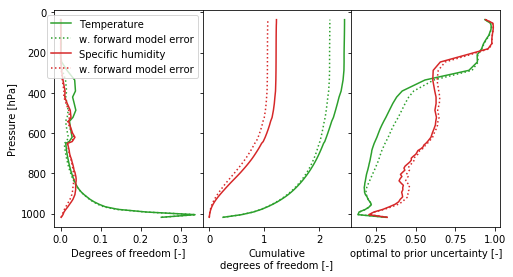

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(8,4))

T, Q = [(x) for x in supporting_routines.splitTQ(oe_ref.dgf_x)]
T_e,Q_e = [(x) for x in supporting_routines.splitTQ(oe_b.dgf_x)]

ax1.plot(T, pressure.sel(season=season)/100, color='C2', label= 'Temperature')
ax1.plot(T_e, pressure.sel(season=season)/100, color='C2', ls=':', label= 'w. forward model error')

ax1.plot(Q, pressure.sel(season=season)/100, color='C3', label= 'Specific humidity')
ax1.plot(Q_e, pressure.sel(season=season)/100, color='C3', ls=':', label= 'w. forward model error')

T, Q = [np.cumsum(x) for x in supporting_routines.splitTQ(oe_ref.dgf_x)]
T_e,Q_e = [np.cumsum(x) for x in supporting_routines.splitTQ(oe_b.dgf_x)]

ax2.plot(T, pressure.sel(season=season)/100, color='C2', label= 'Temperature')
ax2.plot(T_e, pressure.sel(season=season)/100, color='C2', ls=':', label= 'w. forward model error')

ax2.plot(Q, pressure.sel(season=season)/100, color='C3', label= 'Specific humidity')
ax2.plot(Q_e, pressure.sel(season=season)/100, color='C3', ls=':', label= 'w. forward model error')


T, Q = supporting_routines.splitTQ(oe_ref.x_op_err/oe_ref.x_a_err)
T_e,Q_e = supporting_routines.splitTQ(oe_b.x_op_err/oe_b.x_a_err)

ax3.plot(T, pressure.sel(season=season)/100, color='C2', label= 'Temperature')
ax3.plot(T_e, pressure.sel(season=season)/100, color='C2', ls=':', label= 'w. forward model error')

ax3.plot(Q, pressure.sel(season=season)/100, color='C3', label= 'Specific humidity')
ax3.plot(Q_e, pressure.sel(season=season)/100, color='C3', ls=':', label= 'w. forward model error')

ax1.legend()
ax2.set_xlabel('Cumulative\ndegrees of freedom [-]')
ax1.set_xlabel('Degrees of freedom [-]')
ax3.set_xlabel('optimal to prior uncertainty [-]')

ax1.set_ylabel('Pressure [hPa]')
ax1.invert_yaxis()    

fig.subplots_adjust(wspace=0)